# Séance 1 - Réseau dense

Dans cette séance nous travaillerons avec le dataset d'image MNIST. Il correspond à des images de chiffres manuscrit. Notre objectif est de construire un réseau de neurones dense capable d'identifier le chiffre manuscrit écrit.

Commençons par importer quelques librairies qui nous serons utile pour la suite:
* **Numpy** : Calcul matriciel
* **Pandas** : Travail avec des DataFrame
* **Matplotlib** : Graphiques, et on utilise également la sur-couche **seaborn**
* **Tensorflow** : librairie qui permet la définition de réseau de neurones, et une *interface* plus simple d'utilisation **Keras**

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

Importons les données et créons immédiatement trois jeu de données:
* **Train** : dataset qui sert d'entraînement à l'algorithme
* **Validation** : dataset qui permettra à l'algorithme de mesurer sa performance sur un jeu différent du *train*
* **Test** : dataset non vu lors de l'entraînement pour contrôler la performance de l'algorithme

Par définition du dataset, le jeu de test est composée de 10000 images et le jeu d'entraînement et de validation c'est 60000. Nous allons dédier 80% au jeu d'entraînement et 20% pour la validation.

In [2]:
from sklearn.model_selection import train_test_split

mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = (mnist.load_data())
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

11490434/11490434 [==============================] - 0s 0us/step


Regardons les dimensions des trois datasets :

In [3]:
for (dataset, name) in zip([X_train, X_valid, X_test], ["Train", "Validation", "Test"]):
  print(name, ":", dataset.shape)

Train : (48000, 28, 28)
Validation : (12000, 28, 28)
Test : (10000, 28, 28)


Visualisons quelques exemples d'images du dataset d'entraînement:

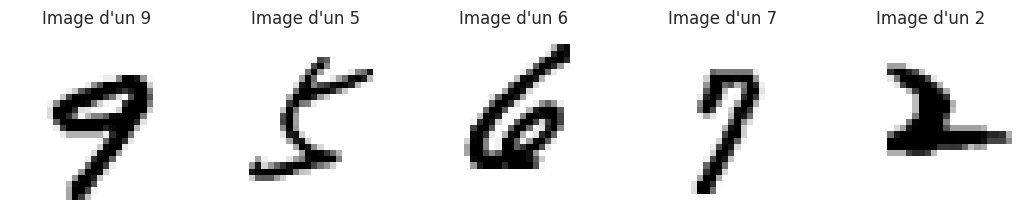

In [4]:
n = 5

plt.figure(figsize=(13, 6))
for plot_index in range(1, n+1):
  plt.subplot(1, n, plot_index)
  index = np.random.randint(low=0, high=len(X_train))
  plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
  plt.title("Image d'un %d" % y_train[index])
  plt.axis('off')
plt.show()

Il ne nous reste plus qu'à décrire le réseau de neurones !

Avant ça, nous savons qu'un réseau dense s'entraîne à partir de vecteur d'informations. Or une image est une matrice, pas un vecteur.
Pour pouvoir se placer dans le bon cadre de travail, nous utiliserons la couche *Flatten* qui prend une matrice de dimension $(height, width, channel)$ et renvoie un vecteur de taille $height \times width \times channel$.
Dans le cadre des données MNIST, $channel=1$ puisque nous sommes en niveau de gris, et $height=width=28$. On aura un vecteur de 784 dimensions.

Une fois que nous aurons décrit l'ensemble du réseau, nous devrons terminer le réseau par une couche avec dix neurones : un pour chaque classe. Pour s'assurer que l'on aura une estimation de probabilité d'appartenance à la classe, on utilisera la fonction softmax. Pour un vecteur $x = (x_0, x_1, \ldots, x_n)$ on a:

$$\text{softmax}(x)_j = \frac{e^{x_j}}{\displaystyle \sum_{i=0}^n e^{x_i}}$$



## Mon premier réseau de neurones dense

On veut définir le réseau suivant:
* **Couche cachée 1** : 256 neurones avec fonction d'activation ReLU
* **Couche cachée 2** : 128 neurones avec fonction d'activation ReLU

On peut définir de plusieurs manières un réseau de neurones. La première est de la même manière qu'une liste à laquelle on ajoute des couches en utilisation le template de modèle *Sequential* :

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

En début de réseau de neurones on doit définir la dimension de l'input: ici (28, 28). Le reste des dimensions pour l'ensemble des couches qui lui succède sont calculées automatiquement.

La deuxième manière est directement sous le format d'une liste:

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

Un bon exercice est de calculer à la main le nombre de paramètres de son réseau de neurones.
* Pour la couche caché 1, on a 256 neurones qui sont connecté à 784 input. On a donc : 256 * (784 + 1) = 200960 paramètres
* Pour la couché 2, on a 128 neurones qui sont connecté à 256 inputs. On a donc : 128 * (256 + 1) = 32896 paramètres
* Pour la dernière couche, on a 10 neurones qui sont connecté à 128 inputs. On a donc : 10 * (128 + 1) = 1290 paramètres

Au total on a donc 235146 paramètres dans ce réseau ! On peut demander ce détail directement au modèle avec la méthode *summary*:

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


On peut même demander un image de l'architecture:

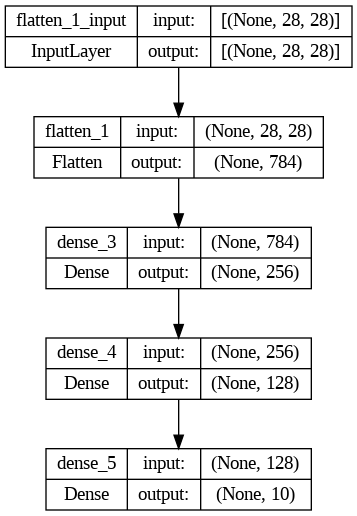

In [8]:
keras.utils.plot_model(model, show_shapes=True)

Nous avons décrit l'architecture du réseau de neurones. Il faut maintenant que nous définissions comment il va s'entraîner. Nous devons spécifier:

* **Loss** : quelle fonction de perte est à minimiser ?
* **Optimizer** quel schéma de descente de gradient est à utiliser ?
* **Metrics** : quelles métrique de performance souhaite-on observer pendant l'entraînement ?

Puisque nous travaillons sur un problème de classification avec plusieurs classes, la fonction de perte *sparse_categorical_crossentropy* est celle qu'il nous faut.

Concernant l'*optimizer* il y a plusieurs possibilités que nous verrons dans une prochaine séance. Pour le moment nous travaillerons avec une descente de gradient stochastique par mini-batch. Pour la définir, nous devons statuer sur:
* **Learning rate** : pas de descente, on décide de choisir la valeur 0.001
* **Batch size** : nombre d'observations à considérer pour chacune des passes. On décide de prendre 32 images par batch. Cette valeur sera à renseigner juste après

Pour les métriques, nous suivrons l'accuracy parce que la distribution des catégories à prédire n'est pas déséquilibrées.

In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])

Le modèle est maintenant prêt à être entraîné, il nous reste à lui indiquer:
* **Données** : jeu d'entraînement et jeu de validation
* **Époques** : le nombre de passes à réaliser sur l'ensemble du dataset
* **Batch size** : le nombre d'observations pour chaque batch, nous avions décidé juste avant que ce serait 32

In [10]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/10
1500/1500 [==============================] - 23s 14ms/step - loss: 1.4795 - accuracy: 0.8254 - val_loss: 0.3893 - val_accuracy: 0.8903
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3100 - accuracy: 0.9120 - val_loss: 0.3082 - val_accuracy: 0.9130
Epoch 3/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2257 - accuracy: 0.9329 - val_loss: 0.2739 - val_accuracy: 0.9249
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1815 - accuracy: 0.9449 - val_loss: 0.2516 - val_accuracy: 0.9304
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1514 - accuracy: 0.9538 - val_loss: 0.2288 - val_accuracy: 0.9385
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1296 - accuracy: 0.9602 - val_loss: 0.2179 - val_accuracy: 0.9413
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1109 - accuracy: 0.9660 - val_loss: 0.2123 - val_accurac

Ca y est ! Nous avons entraîné notre premier réseau de neurone dense, avec de très bonne performances en plus !

Nous avons créé l'objet *history*, voyons ce qu'il contient:

In [11]:
historic = pd.DataFrame(history.history)
print(historic)

       loss  accuracy  val_loss  val_accuracy
0  1.479526  0.825375  0.389308      0.890250
1  0.309982  0.912000  0.308237      0.913000
2  0.225686  0.932917  0.273943      0.924917
3  0.181475  0.944854  0.251566      0.930417
4  0.151376  0.953750  0.228778      0.938500
5  0.129583  0.960187  0.217903      0.941250
6  0.110903  0.966042  0.212268      0.942417
7  0.098539  0.970104  0.216124      0.942583
8  0.087330  0.973104  0.220064      0.940500
9  0.077412  0.976479  0.207860      0.948250


Il s'agit de l'ensemble des valeurs suivies pendant l'entraînement du modèle, nous allons donc pouvoir tracer des courbes d'apprentissage.

In [12]:
def plot_learning_curves(history, figsize=(13, 6)):
    historic = pd.DataFrame(history.history)
    historic.plot(figsize=figsize)

    plt.xlabel("Epoch")
    plt.ylim(0, 1)
    plt.show()

Et sur notre exemple cela donne:

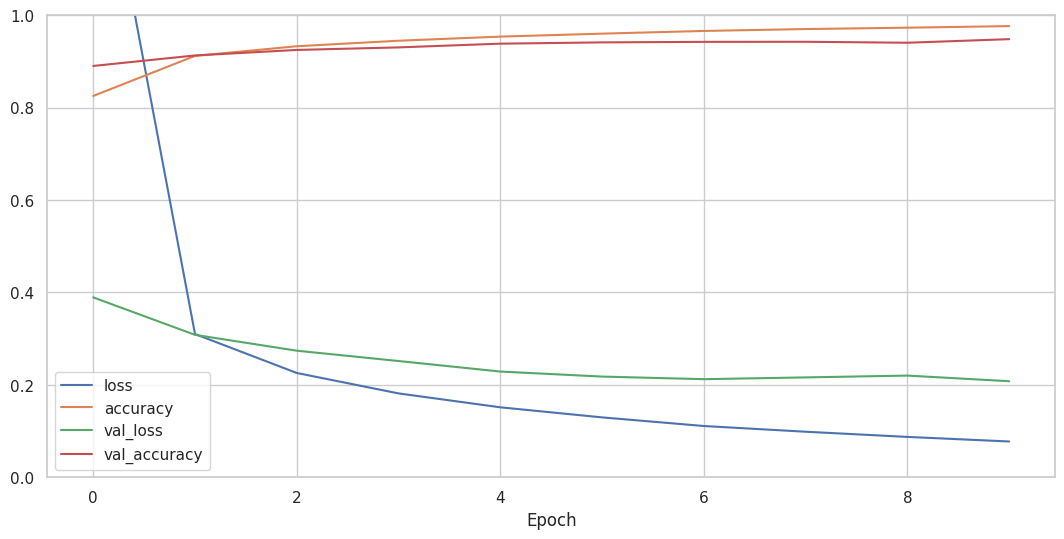

In [13]:
plot_learning_curves(history)

Nous aimerions *voir* les prédictions du réseau de neurones sur le jeu de test. Commençons par calculer les prédictions:

In [14]:
y_pred = model.predict(X_test)

313/313 [==============================] - 1s 3ms/step


Regardons pour la première image:

In [15]:
print(y_pred[0])

[1.6750800e-23 4.5735412e-12 2.9414346e-07 3.4721201e-16 1.2317560e-18
 2.0447712e-15 4.8107054e-20 9.9999970e-01 6.4141057e-18 1.7600419e-08]


Nous avons un vecteur de 10 valeurs qui correspondent à chacun des 10 neurones de la couche de sortie. Si l'on somme y_pred[0] on obtient 1 car c'est un vecteur de probabilité. Si l'on en crois la valeur, l'image 0 du dataset de test est un 7 : vérifions.

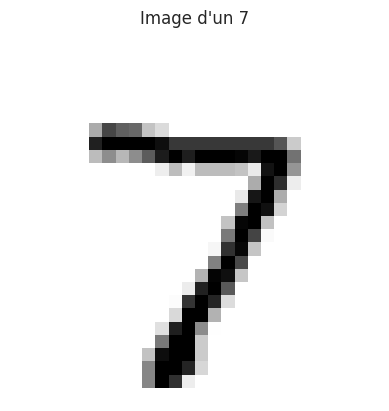

In [16]:
plt.imshow(X_test[0], cmap="binary", interpolation="nearest")
plt.title("Image d'un %d" % y_test[0])
plt.axis('off')
plt.show()

C'est correct ! Voici comment obtenir automatiquement la classe prédite:

In [17]:
np.argmax(y_pred[0])

7

Plutôt que d'observer à la main les images une par une, nous pouvons en visualiser plusieurs d'un coup:

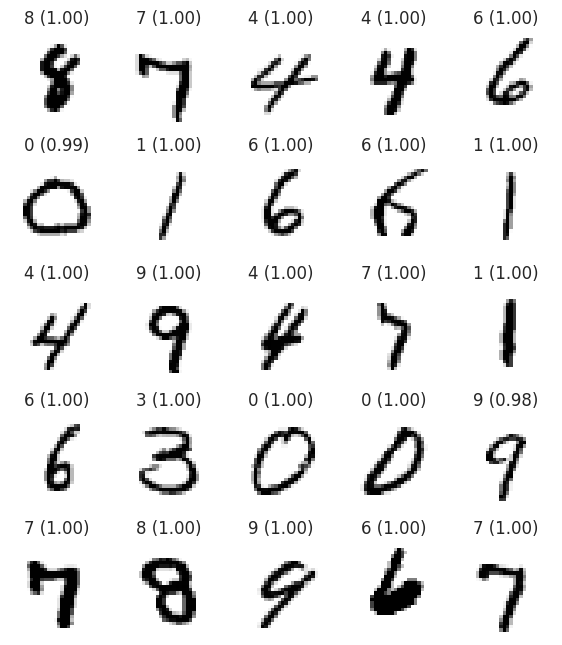

In [18]:
def show_prediction(index, show=True):
    plt.imshow(X_test[index], cmap="binary", interpolation="nearest")
    title = "%d (%0.2f)" % (np.argmax(y_pred[index]), np.max(y_pred[index]))
    plt.axis('off')
    plt.title(title)
    if show: plt.show()


n_rows = 5
n_cols = 5
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        show_prediction(np.random.randint(low=0, high=len(X_test)), show=False)
plt.show()

## Notre première erreur

Nous avons entraîné un réseau de neurones en utilisant une descente de gradient. Pour cela on souhaite avoir des données standardisées et si possible proche d'une loi normale (nous verrons pourquoi dans une séance prochaine).
Pour standardiser une colonne $X$, on calcule:

$$\tilde{X} = \frac{X - \overline{X}}{\sigma(X)}$$

Avec $\sigma(X)$ qui est l'écart-type de la variable $X$. Il faut prêter attention aux termes $\overline{X}$ et $\sigma(X)$ : ils ne doivent pas être calculé pour chaque dataset ! Ces valeurs sont calculés pour le dataset d'entraînement **puis** appliquées aux autres datasets.
En effet, on ne connait pas à l'avance les valeurs que vont prendre le dataset de test ou de validation par exemple, donc on réaliserait une contamination des données.
Le mieux pour éviter cette erreur est d'exploiter la méthode *StandardScaler* de scikit-learn.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

Entraînons un nouveau modèle, identique en design, avec les données standardisées pour voir la différence.

In [20]:
model_standard = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model_standard.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history_standard = model_standard.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/10
1500/1500 [==============================] - 7s 4ms/step - loss: 1.3125 - accuracy: 0.6520 - val_loss: 0.7626 - val_accuracy: 0.8232
Epoch 2/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.5959 - accuracy: 0.8519 - val_loss: 0.5013 - val_accuracy: 0.8750
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.4324 - accuracy: 0.8846 - val_loss: 0.4121 - val_accuracy: 0.8958
Epoch 4/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3614 - accuracy: 0.8997 - val_loss: 0.3653 - val_accuracy: 0.9057
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3192 - accuracy: 0.9087 - val_loss: 0.3347 - val_accuracy: 0.9128
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2902 - accuracy: 0.9163 - val_loss: 0.3146 - val_accuracy: 0.9168
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2681 - accuracy: 0.9219 - val_loss: 0.3003 - val_accuracy:

Comparons les deux courbes d'apprentissages : avec et sans standardisation des données.

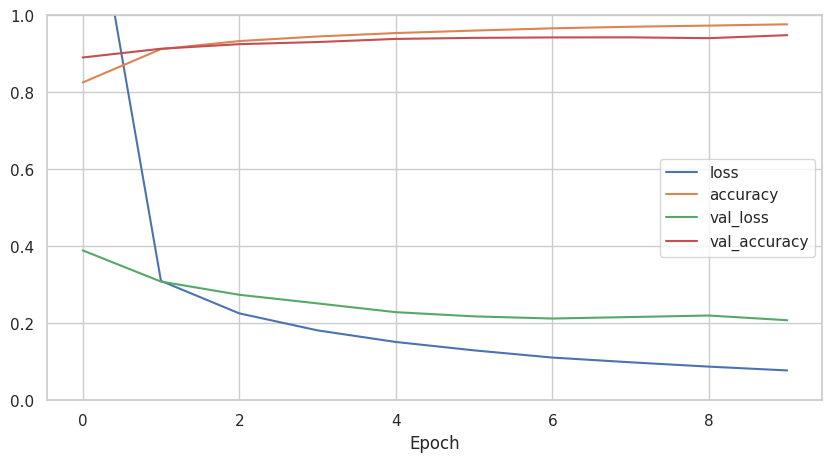

In [21]:
plot_learning_curves(history, figsize=(10, 5))

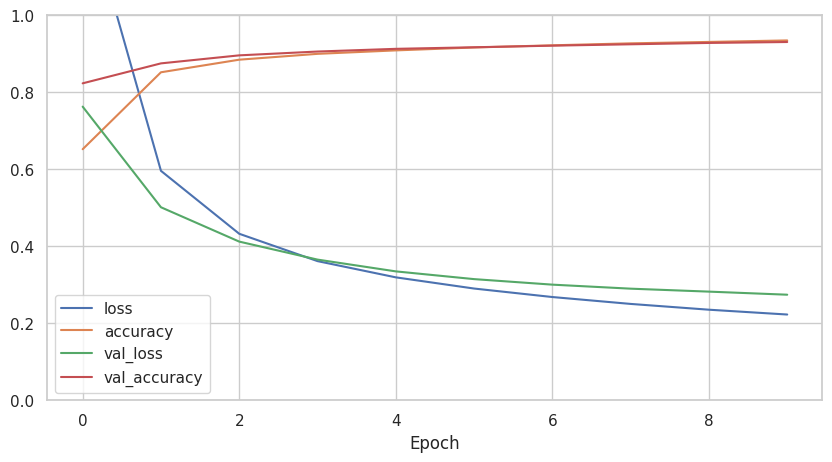

In [22]:
plot_learning_curves(history_standard, figsize=(10, 5))

On observe une chose importante : les courbes d'apprentissages sont plus douces quand on standardise les données. De plus l'écart entre les courbes d'entraînement et de validation sont plus proches. C'est signe d'un entraînement plus sain car il y a moins de sur-apprentissage.

A l'avenir, il faut systématiquement standardiser les données que l'on donne à un algorithme qui s'entraîne avec une méthode de descente de gradient.



## A vous de jouer !

Maintenant que l'on a vu comment définir un réseau de neurones, l'entraîner et contrôler ses résultats, c'est à vous de traiter au moins un des sujets proposés.